In [18]:
from tensorflow.keras.applications import resnet50
import pandas as pd
import numpy as np
import tensorflow as tf

from keras.utils import to_categorical
from keras.preprocessing import image
import PIL.Image, PIL.ImageFont, PIL.ImageDraw


In [19]:
BATCH_SIZE = 32
classes = [str(i) for i in range(1,11,1)]

In [20]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

# expand new axis, channel axis
x_train = np.expand_dims(x_train, axis=-1)

# [optional]: we may need 3 channel (instead of 1)
x_train = np.repeat(x_train, 3, axis=-1)

# resize the input shape , i.e. old shape: 28, new shape: 32
x_train = tf.image.resize(x_train, [32,32]) # if we want to resize

print(x_train.shape, y_train.shape)

x_val = np.expand_dims(x_val, axis=-1)

# [optional]: we may need 3 channel (instead of 1)
x_val = np.repeat(x_val, 3, axis=-1)

# resize the input shape , i.e. old shape: 28, new shape: 32
x_val = tf.image.resize(x_val, [32,32]) # if we want to resize

# one hot
# y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
# y_val = tf.keras.utils.to_categorical(y_val , num_classes=10)

print(x_val.shape, y_val.shape)

(60000, 32, 32, 3) (60000,)
(10000, 32, 32, 3) (10000,)


In [21]:
def preprocess_image_input(input_images):
  output_images = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_images

In [22]:
train_X = preprocess_image_input(x_train)
valid_X = preprocess_image_input(x_val)

In [23]:
def feature_extractor(inputs):

  return tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)

In [24]:
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

In [25]:
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    return classifier(resnet_feature_extractor)

In [26]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098

In [27]:
EPOCHS = 3
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/3
938/938 [==============================] - 348s 342ms/step - loss: 0.1123 - accuracy: 0.9722 - val_loss: 0.1261 - val_accuracy: 0.9710
Epoch 2/3
938/938 [==============================] - 318s 339ms/step - loss: 0.0162 - accuracy: 0.9955 - val_loss: 0.0325 - val_accuracy: 0.9910
Epoch 3/3
938/938 [==============================] - 311s 332ms/step - loss: 0.0069 - accuracy: 0.9984 - val_loss: 0.0225 - val_accuracy: 0.9935


In [28]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 15s 94ms/step - loss: 0.0225 - accuracy: 0.9935


In [29]:
from matplotlib import pyplot as plt


def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

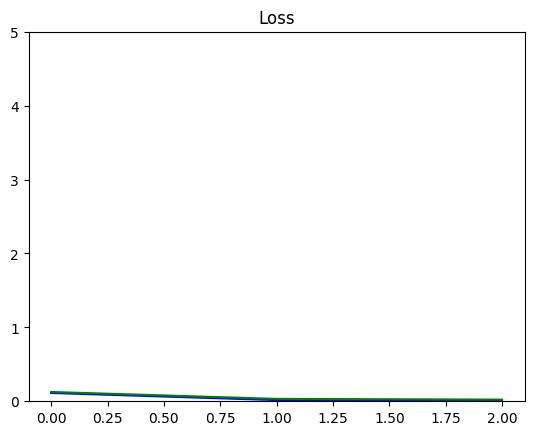

In [30]:
plot_metrics("loss", "Loss")

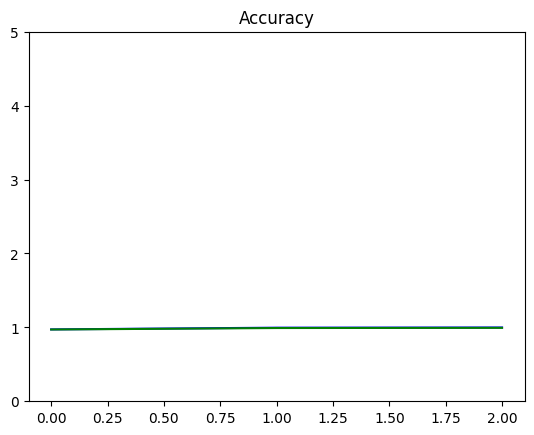

In [31]:
plot_metrics("accuracy", "Accuracy")

In [ ]:
import keras
keras.layers.experimental